In [1]:
from itertools import chain
from functools import reduce

import pandas as pd
import numpy as np
from sklearn.manifold import MDS
import scipy

from matplotlib.colors import LinearSegmentedColormap
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

AAs = 'ACDEFGHIKLMNPQRSTVWY-'
WT = "MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE"

models = ['LR', 'FCN', 'CNN0', 'CNN1', 'CNN2', 'GCN', 'EnsM', 'EnsC']
colors = {'LR':'#F57685', 'FCN':'#B51D49', 'CNN0':'#47A2F7','CNN1':'#47A2F7',
          'CNN2':'#47A2F7', 'GCN':'#6561B8', 'EnsM':'#56AC9D', 'EnsC':'#11677E'}
bcolor = '#E1E2E5'

In [2]:
df = pd.read_csv("designs.csv", index_col=0)
for model in models:
    mod1 = [m==model for m in df.model]
    mod2 = [(len(str(m))>4) and (model in m) for m in df.model] # To catch few cases where multiple models designed same sequence "['fcn', 'lr', 'lcb'], indices of replicate sequences: [31, 93, 192]"
    df[model] = [any((mod1[i],mod2[i])) for i in range(len(mod1))]

designs_df = df.loc[df.num_mut > 2]

lib10 = designs_df[designs_df.num_mut == 10]

In [3]:
def ham_dist(q,r):
	return sum([1 for q,r in zip(q,r) if q != r])

def hd_matrix(qs: list):
	hd_i = []

	for q in qs:
		hd_i.append([ham_dist(q, r) for r in qs])

	return np.vstack(hd_i)

mds_df = pd.melt(designs_df.reset_index(drop=False), id_vars=['seq_id', 'num_mut', 'seq'], value_vars=['LR','FCN','CNN0','CNN1','CNN2','GCN','EnsM','EnsC'], var_name='model')
mds_df = mds_df[mds_df.value]
mds_df['seq_int'] = [int(sid.split('_')[-1]) for sid in mds_df.seq_id]
mds_df = mds_df.sort_values(by='seq_int').reset_index(drop=True)

hdm = hd_matrix(mds_df.seq.tolist())
embedding = MDS(n_components=2, dissimilarity='precomputed', n_init=4, max_iter=300, random_state=42)
transformed = embedding.fit_transform(hdm)

mds_df['mds_x'] = transformed[:,0]
mds_df['mds_y'] = transformed[:,1]

Text(0.5, 1.0, 'MDS colored by mutational regime')

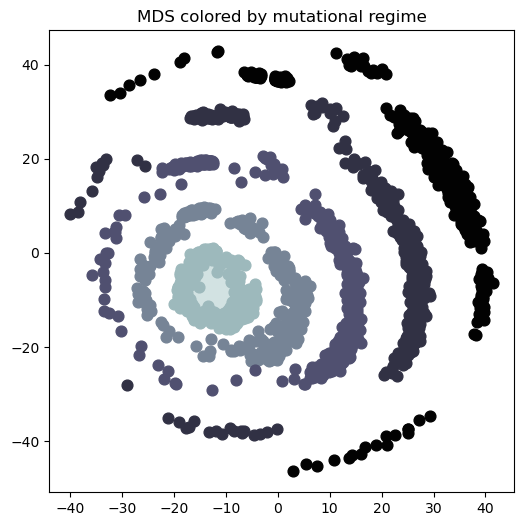

In [4]:
# fig 2b
boner_cmap = matplotlib.cm.get_cmap('bone_r')
dis_colors = [boner_cmap(.13), boner_cmap(.3), boner_cmap(.47), boner_cmap(.64), boner_cmap(.78), boner_cmap(.99)]

plt.figure(figsize=(6,6))
for m, c in zip([5,10,20,30,40,50], dis_colors):
    subset = mds_df[mds_df.num_mut == m]
    x, y = subset.mds_x, subset.mds_y
    plt.scatter(x,y, s=60, color=c)
plt.title('MDS colored by mutational regime')
# plt.savefig('plots/gb1_library_nummut.svg', format='svg')

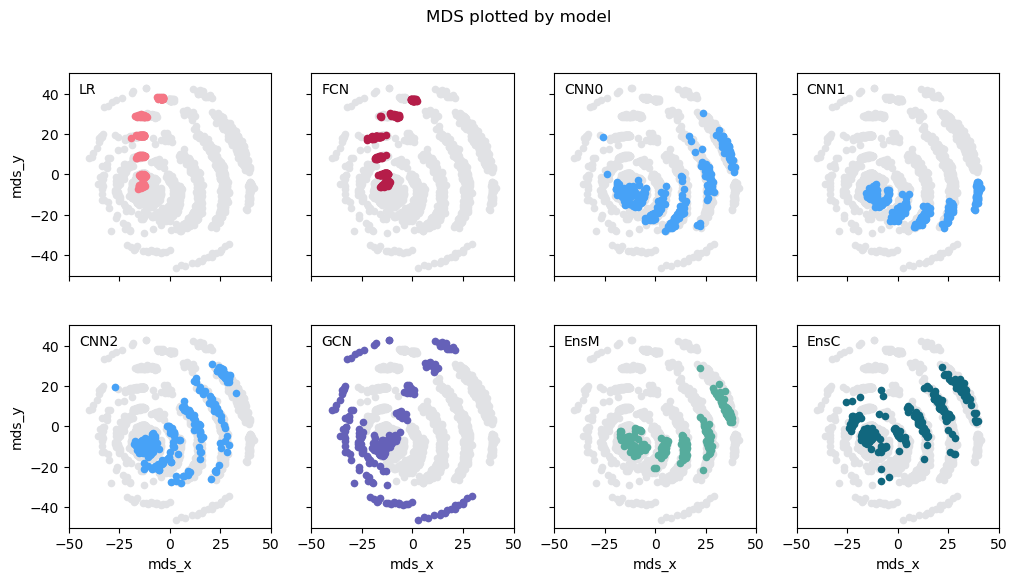

In [5]:
# fig 2c
fig, axs = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(12,6))

for i, (ax, model) in enumerate(zip(axs.flatten(), models)):
    ax.set_ylim((-50, 50))
    ax.set_xlim((-50, 50))

    # plot whole library in grey
    sns.scatterplot(data=mds_df, x='mds_x', y='mds_y', color=bcolor, ax=ax, linewidth=0, s=30)

    # plot individual model conditions in specific color
    model_df = mds_df[mds_df.model == model]
    sns.scatterplot(data=model_df, x='mds_x', y='mds_y', color=colors[model], ax=ax, linewidth=0, s=30)

    ax.text(-45, 40, model)
    ax.set_aspect('equal', adjustable='box')
    fig.suptitle('MDS plotted by model')

# plt.savefig('plots/gb1_library_models.svg', format='svg')

Save source data for Figure 2c

In [6]:
# mds_df[['seq_id','model','num_mut','mds_x','mds_y']].to_csv('source_data_files/fig_2c_src.csv')

Save source data for Figure S4

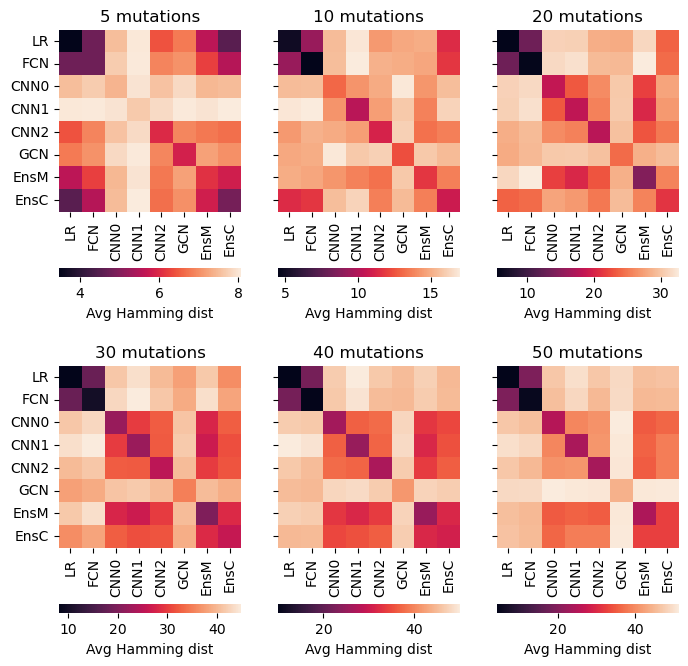

In [7]:
# fig s4
num_muts = [5, 10, 20, 30, 40, 50]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 8), sharey=True)

for i, num_mut in zip(range(len(num_muts)), num_muts):
    ax = axes[i//3,i%3]
    nmut_df = df.loc[df.num_mut == num_mut]
    seqs_by_model = [nmut_df.loc[df[model]].seq for model in models]
    
    dist_matrix = []
    for seqs1 in seqs_by_model:
        avg_dists = []
        for seqs2 in seqs_by_model:
            avg_dists.append(sum(sum(ham_dist(seq1, seq2) for seq1 in seqs1) for seq2 in seqs2)
                             / (len(seqs1)*len(seqs2)))
        dist_matrix.append(avg_dists)
    dist_matrix_df = pd.DataFrame(dist_matrix, index=models, columns=models)
    dist_matrix_df.to_csv(f'source_data_files/fig_s4_hd{num_mut}_src.csv')
    sns.heatmap(dist_matrix_df, ax=ax, square=True, cbar_kws={'label': 'Avg Hamming dist', "orientation": "horizontal", 'pad':0.2})
    ax.set_title(f'{num_mut} mutations')
# plt.savefig('plots/dist_matrix_library.png', dpi=300)

Save source data for Figure S5

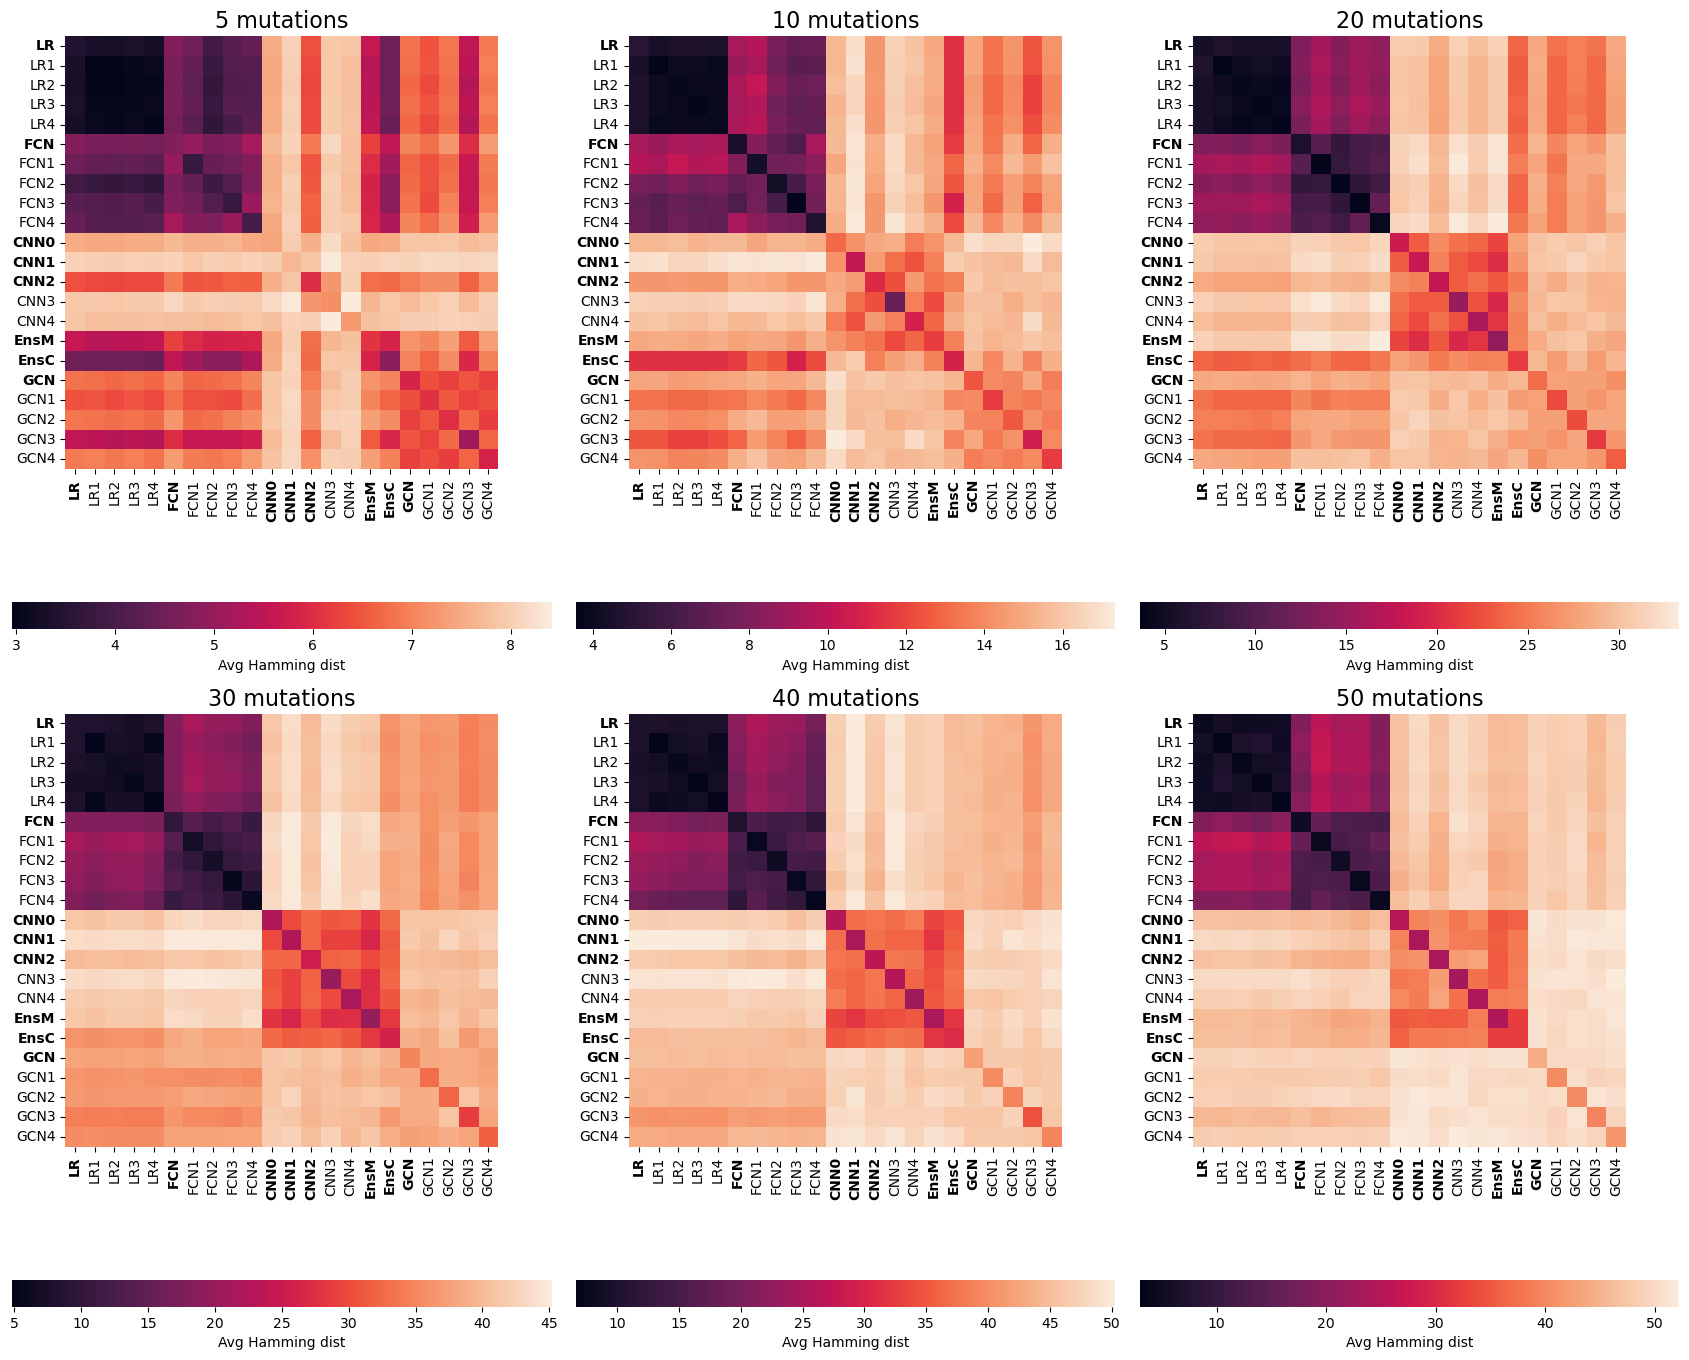

In [8]:
# Fig. S5. Effect of random parameter initialization on designs.

extra_seqs = pd.read_pickle('data/02_03-26-2024_extra_seqs.pkl')
extra_seqs.rename(columns={'mut_seq':'seq', 'nmuts':'num_mut'}, inplace=True)
extra_seqs['model'] = [bm.upper()+str(mi) for bm, mi in zip(extra_seqs.base_model, extra_seqs.model_id)]

textra_seqs = extra_seqs[['model', 'num_mut', 'seq']].copy()

for m in textra_seqs.model.unique():
    textra_seqs[m] = textra_seqs.model == m

hm_seqs = pd.concat([df[['seq', 'num_mut'] + df.columns.tolist()[-8:]], textra_seqs])
hm_seqs.fillna(False, inplace=True)

num_muts = [5, 10, 20, 30, 40, 50]
extra_models = {'LR':'LR',
                'LR25':'LR1',
                'LR5':'LR2',
                'LR61':'LR3',
                'LR86':'LR4',
                'FCN':'FCN',
                'FCN23':'FCN1',
                'FCN50':'FCN2',
                'FCN19':'FCN3',
                'FCN32':'FCN4',
                'CNN0':'CNN0',
                'CNN1':'CNN1',
                'CNN2':'CNN2',
                'CNN44':'CNN3',
                'CNN66':'CNN4',
                'EnsM':'EnsM',
                'EnsC':'EnsC',
                'GCN':'GCN',
                'GCN50':'GCN1',
                'GCN93':'GCN2',
                'GCN36':'GCN3',
                'GCN39':'GCN4'}

# use more meaningful model names, indicate models used to design library
study_models = ['LR', 'FCN', 'CNN0', 'CNN1', 'CNN2', 'EnsM', 'EnsC', 'GCN']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(17, 14), layout='tight', sharey=False, facecolor='white')
# plt.figure(facecolor='white')

for i, num_mut in zip(range(len(num_muts)), num_muts):
    ax = axes[i//3,i%3]
    nmut_df = hm_seqs.loc[hm_seqs.num_mut == num_mut]
    seqs_by_model = [nmut_df.loc[hm_seqs[model]].seq for model in extra_models]
    
    dist_matrix = []
    for seqs1 in seqs_by_model:
        avg_dists = []
        for seqs2 in seqs_by_model:
            avg_dists.append(sum(sum(ham_dist(seq1, seq2) for seq1 in seqs1) for seq2 in seqs2)
                             / (len(seqs1)*len(seqs2)))
        dist_matrix.append(avg_dists)
    dist_matrix_df = pd.DataFrame(dist_matrix, index=list(extra_models.keys()), columns=list(extra_models.keys()))
    dist_matrix_df.to_csv(f'source_data_files/fig_s5_hd{num_mut}_src.csv')
    sns.heatmap(dist_matrix_df, ax=ax, square=True, cbar_kws={'label': 'Avg Hamming dist', "orientation": "horizontal", 'pad':0.2})
    ax.set_title(f'{num_mut} mutations', fontsize=16)
    ax.set_yticks(np.arange(len(extra_models))+.5)
    ax.set_yticklabels(list(extra_models.values()))
    ax.set_xticklabels(list(extra_models.values()))

    # bold text for original models used in study
    for xlab, ylab in zip(ax.get_xticklabels(), ax.get_yticklabels()):
        if xlab.get_text() in study_models:
            xlab.set_fontweight('bold')
            ylab.set_fontweight('bold')
# plt.savefig('plots/dist_matrix_extra_seqs.png', dpi=300, transparent=False)

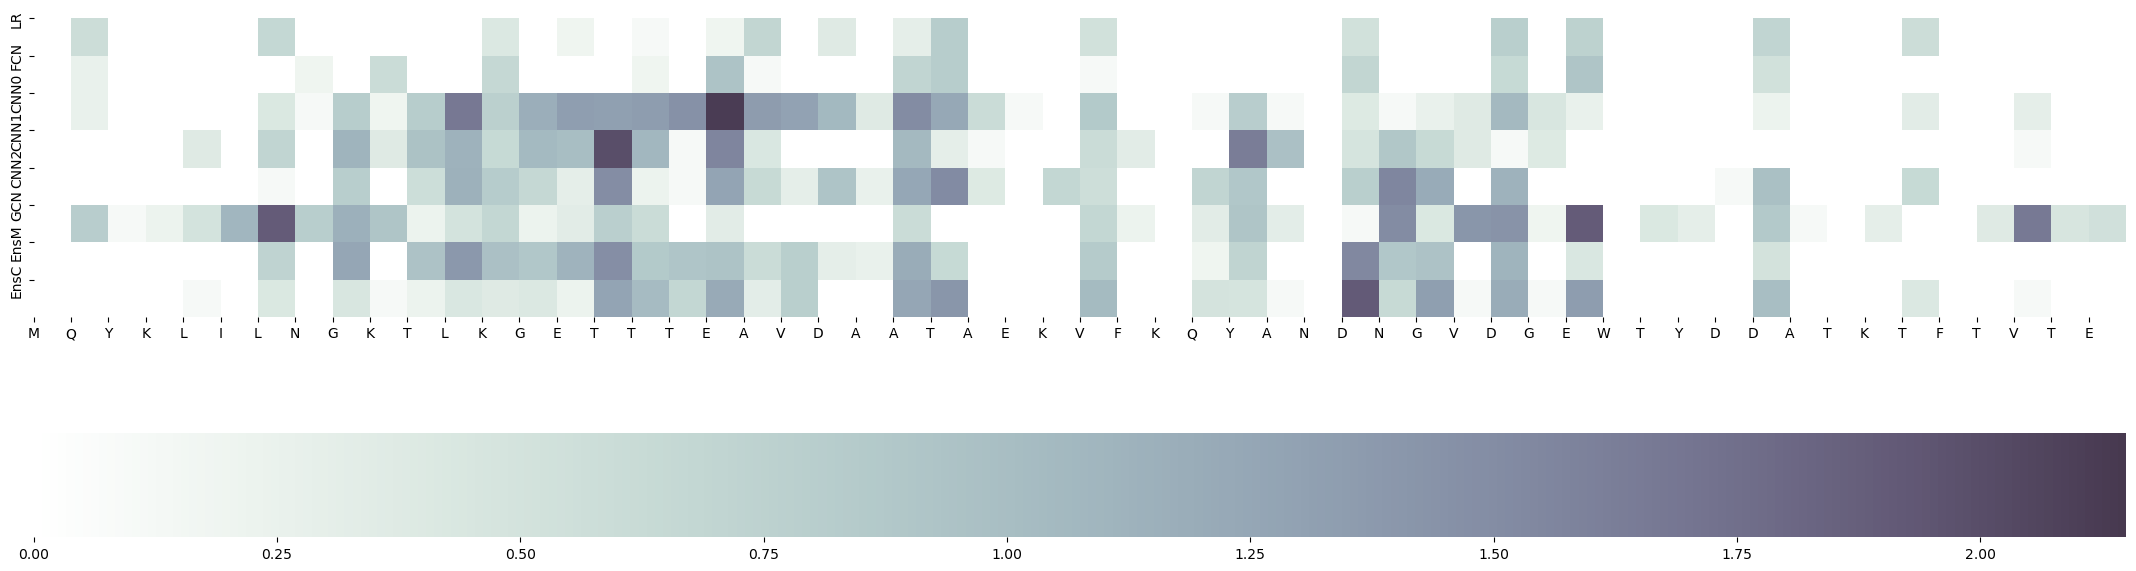

In [9]:
#fig 2d

def counts_to_probabilities(arr: np.ndarray):

    aa_dict = {aa:0 for aa in 'ACDEFGHIKLMNPQRSTVWY'}

    aas, counts = np.unique(arr, return_counts=True)
    counts = counts / counts.sum()

    aa_dict.update({aa:count for aa, count in zip(aas, counts)})

    return np.array(list(aa_dict.values()))


def sequence_entropy(seq_list: list[str], axis=1):

    seq_arr = np.vstack([np.array(list(s)) for s in seq_list])
    probabilities = np.vstack([counts_to_probabilities(i).T for i in seq_arr.T])

    # return probabilities
    return scipy.stats.entropy(probabilities, qk=None, base=None, axis=axis)

model_entropies = np.vstack([sequence_entropy(designs_df[(designs_df.num_mut == 10) & 
                                                         (designs_df[model])].seq.tolist()) for model in models])

custom_bonelike = LinearSegmentedColormap.from_list('palette', [[1.0, 1.0, 1.0],
 [0.9288068957722505, 0.9546925192067743, 0.9359270354015852],
 [0.8528706700407475, 0.9063097031737415, 0.8809675625807116],
 [0.7764937354167123, 0.8522542096435965, 0.8341061496377662],
 [0.7033204630045682, 0.7904748416674883, 0.7922087139026253],
 [0.6355933609625329, 0.7196837412447831, 0.7503954178432785],
 [0.5735128564149428, 0.6394164793558497, 0.7026010008568161],
 [0.5147052949134884, 0.5498780985827206, 0.6421932655887311],
 [0.45366975863152126, 0.4514715157919485, 0.5624124887995992],
 [0.3806401778011136, 0.343684732006475, 0.45604243853708415],
 [0.27705785742311567, 0.2217130205190177, 0.31176198544174705]])

plt.figure(figsize=(27,10))
sns.heatmap(model_entropies, square=True, cmap=custom_bonelike, cbar_kws={"orientation": "horizontal"}, cbar=True, vmax=2.15)
plt.xticks(list(range(len(WT))), list(WT))
plt.yticks(list(range(len(models))), models)

plt.show()

Save source data for Figure 2d

In [10]:
# save soure data
entropy_df = pd.DataFrame(data=model_entropies, columns=list(WT), index=models)
entropy_df.to_csv('source_data_files/fig_2d.csv')

Save source data for Figure S7

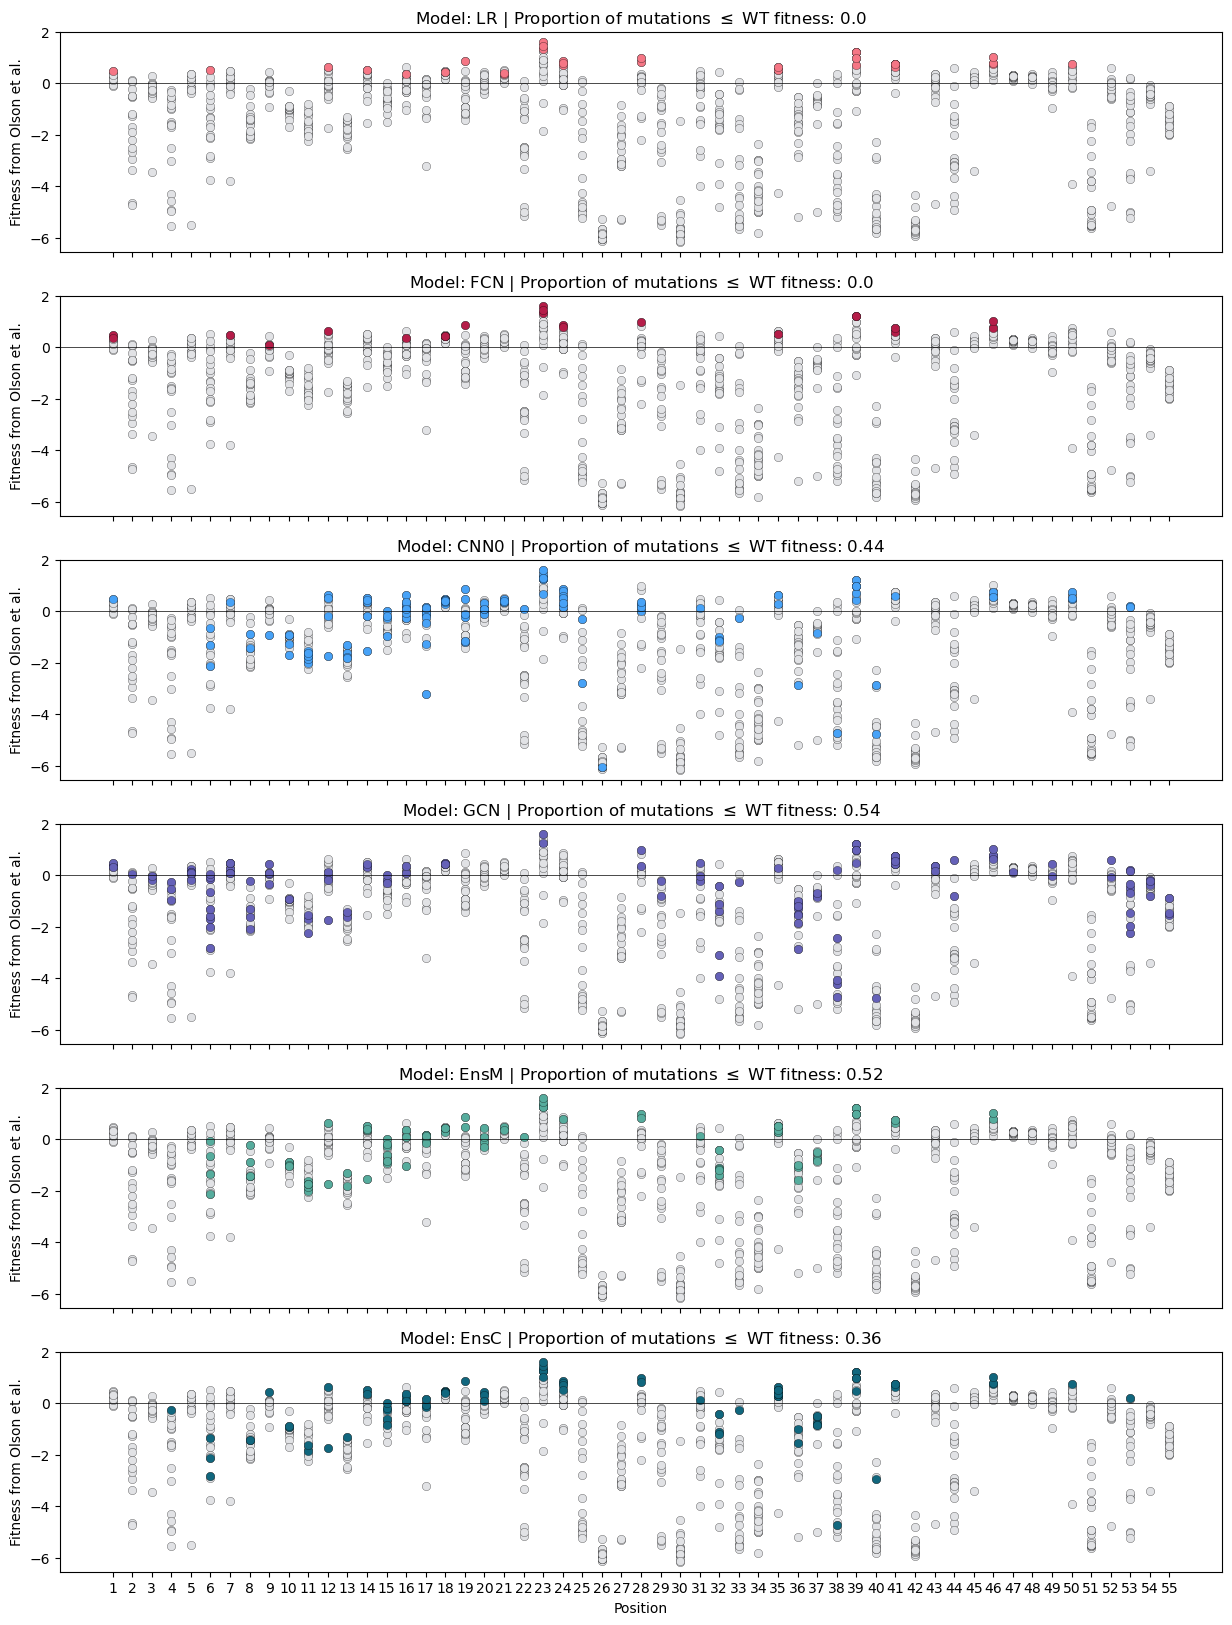

In [11]:
# fig s7
plots = ['LR', 'FCN', 'CNN0', 'GCN', 'EnsM', 'EnsC']

smuts = pd.read_csv('data/smut_fits_olson.csv', index_col=0)
smuts['position'] = [v[1:-1] for v in smuts.variant]
smuts.set_index('variant', inplace=True, drop=False)

def format_mutations(muts: str) -> list:
    return "".join([m for m in muts if m not in " '()"]).split(',')

fig, axs = plt.subplots(len(plots), 1, figsize=(15, 20), sharex=True, sharey=True)

src_df = smuts.copy()

for model, ax in zip(plots, axs.flatten()):
    unique_mutants = list(set(list(chain(*[format_mutations(mutants) for mutants in 
                                           df[(df[model]) & (df.num_mut == 10)].mutations]))))
    # print(mut_df)
    mut_df = smuts.loc[unique_mutants]
    src_df.loc[mut_df.index, model] = True

    sns.scatterplot(data=smuts, x='position', y='score', ax=ax, color=bcolor, edgecolor='k', linewidth=0.2)
    sns.scatterplot(data=mut_df, x='position', y='score', ax=ax, color=colors[model], 
                    edgecolor='k', linewidth=0.2)
    ax.axhline(0, color='black', linewidth=0.5)
    
    ax.set_ylabel('Fitness from Olson et al.')
    ax.set_xlabel('Position')
    ax.set_title('Model: '+model+r' | Proportion of mutations $\leq$ WT fitness: '
                 +str(round(len([s for s in mut_df.score.tolist() if s <= 0]) / len(mut_df), 2)))
# plt.savefig('plots/single_mutations.png', dpi=300)

In [12]:
src_df = src_df[['position', 'score', 'LR', 'FCN', 'CNN0', 'GCN', 'EnsM', 'EnsC']]
src_df.fillna(False, inplace=True)
src_df.to_csv('source_data_files/fig_s7_src.csv')